# Final Project - 42578 Advanced Business Analytics (F22)
## Engagement prediction of news articles on Facebook

Technical University of Denmark (DTU), 11th of May 2022

*This notebook is made in collaboration between:*  
**s184314**, **s184288**, **s184313**, **s183568** and **184304**.


#### Structure of this notebook
The notebook consists of the following parts:   
1. [Introduction to the project](#part1)  
    1.1.  [Description of chosen dataset](#part11)   
    1.2. [Research questions](#part12)  
2. [Data cleaning & Preprocessing](#part2)  
3. [Descriptive statistics](#part3)  
4. [Exploratory analysis](#part4)  
    4.1. [Sentiment and Subjectivity analysis](#part41)  
    4.2. [Topic modelling](#part42)  
    4.3. [HSV image analysis](#part43) 
5. [Preparation for predictions](#part5)  
6. [Prediction models](#part6)    
    6.1. [Baseline model](#part61)    
    6.2. [Light GBM regressor ](#part62)    
    6.3. [Convolutional neural network (CNN)](#part63)   
    6.4. [BERT model](#part64)  
    6.5. [BERT model with simple extension](#part65)  
    6.6. [Combined model](#part66)    
    6.7. [Results](#part67)
7. [Discussion and conclusion](#part7)

<a id='part1'></a>

# Part 1 - Introduction to the project

The topic of this project is *Engagement prediction of news articles on Facebook*. In order to perform a prediction of the engagement a thorough cleaning of the dataset will be carried out. Hereafter, descriptive statistics will take place, which explore the importance of the different attributes. Both low complexity models and high complexity models will be tested and evaluated to finally select the most suitable model for prediction of article engagement on Facebook. 

<a id='part11'></a>
## 1.1 Description of chosen dataset
For the project the provided dataset *Internet news data with readers engagement* will be used. The dataset has been downloaded from [Kaggle](https://www.kaggle.com/szymonjanowski/internet-articles-data-with-users-engagement). 


The dataset contains basic information about the news articles and all attributes can be seen in the table below. 

| Attribute | Description | 
| :- | :- |
| source_id | Publisher unique identifier |
| source_name | Publisher name |
| author | The author of the article |
| title | The headline of the article |
| description | A short description of the article |
| url | Article URL from publisher website |
| url_to_image | URL to main image associated with the article |
| published_at | Exact time and date of publishing the article |
| content | Unformatted content of the article truncated to 260 characters |
| top_article | Value indicating if article was listed as a top article on publisher website |
| engagement_reaction_count | Users reactions count for posts on Facebook involving article URL |
| engagement_comment_count | Users comments count for posts on Facebook involving article URL |
| engagement_share_count | Users shares count for posts on Facebook involving article URL |
| engagement_comment_plugin_count | Users comments count for Facebook comment plugin on article website |


The dataset consists of 10,436 rows and 14 columns. The data was collected between 03.09.2019 and 03.10.2019 (DD.MM.YYYY). 


<a id='part12'></a>
## 1.2 Research questions

The aim of this project is to analyse how the facebook engagement of news articles is impacted by different attributes and how the engagement best can be predicted. Facebook engagement is important for news websites as it helps them reach beyond its followers. If a news website's Facebook page only has a small amount of followers, but most of them engage with their posts, then their content will appear on many non-followers' Facebook feed. This means that if the news websites achieves a high engagement rate, they will most likely reach a larger audiance in which they have potential to attract new readers to their platform. It is interesting to see if it is possible to predict the engagement of an article, as this has the potential to help publishers improve their engagement. This leads to the following research questions: 

* Which attributes contribute most to the engagement?

* Is there a correlation between the sentiment of an article and the engagement? If so, how can this be used to predict engagement? 

* Which topics can be found in the dataset and can these be used for prediction? 

* What is the performance of a simple ML model and how have previous work performed on this problem? 

* Can the prediction be improved by using neural networks for modeling both the text and image of the article?

<a id='part2'></a>

# Part 2 - Data cleaning & Preprocessing

For the first part of the project, the article data is loaded, and its data formats are checked to make sure that the data has the right formats.
The number of missing values is found for the attribues: `title`, `description`, `URL to image`, and the `total engagement`. We only care about missing values here, as these are the attributes used in the later analysis.

In [67]:
# Loading all relevant packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.dates
import matplotlib.pyplot as plt
from datetime import datetime
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns
from sklearn.feature_extraction import _stop_words
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import mean_squared_error,f1_score,accuracy_score,confusion_matrix, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
import textblob
from wordcloud import WordCloud,STOPWORDS
import re
import gensim
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from lightgbm import LGBMRegressor #import cv2
import requests
import imageio
import urllib.request
import os
import os.path
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
import PIL
from PIL import ImageFile,Image,UnidentifiedImageError
import pickle

plt.rcParams["figure.figsize"] = (20,5)
ImageFile.LOAD_TRUNCATED_IMAGES = True
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS

In [2]:
# Let's load the data
df = pd.read_csv('articles_data.csv', index_col = 0)
df.head(5)

source_id         source_name              author  \
0             reuters             Reuters   Reuters Editorial   
1     the-irish-times     The Irish Times  Eoin Burke-Kennedy   
2     the-irish-times     The Irish Times   Deirdre McQuillan   
3  al-jazeera-english  Al Jazeera English          Al Jazeera   
4            bbc-news            BBC News            BBC News   

                                               title  \
0  NTSB says Autopilot engaged in 2018 California...   
1       Unemployment falls to post-crash low of 5.2%   
2  Louise Kennedy AW2019: Long coats, sparkling t...   
3  North Korean footballer Han joins Italian gian...   
4  UK government lawyer says proroguing parliamen...   

                                         description  \
0  The National Transportation Safety Board said ...   
1  Latest monthly figures reflect continued growt...   
2  Autumn-winter collection features designer’s g...   
3  Han is the first North Korean player in the Se...   
4  The UK government's lawyer, David Johnston arg...   

                                                 url  \
0  https://www.reuters.com/article/us-tesla-crash...   
1  https://www.irishtimes.com/business/economy/un...   
2  https://www.irishtimes.com/\t\t\t\t\t\t\t/life...   
3  https://www.aljazeera.com/news/2019/09/north-k...   
4  https://www.bbc.co.uk/news/av/uk-scotland-4956...   

                                        url_to_image          published_at  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...  2019-09-03T16:22:20Z   
1  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T10:32:28Z   
2  https://www.irishtimes.com/image-creator/?id=1...  2019-09-03T14:40:00Z   
3  https://www.aljazeera.com/mritems/Images/2019/...  2019-09-03T17:25:39Z   
4  https://ichef.bbci.co.uk/news/1024/branded_new...  2019-09-03T14:39:21Z   

                                             content  top_article  \
0  WASHINGTON (Reuters) - The National Transporta...          0.0   
1  The States jobless rate fell to 5.2 per cent l...          0.0   
2  Louise Kennedy is showing off her autumn-winte...          1.0   
3  Han Kwang Song, the first North Korean footbal...          0.0   
4                                                NaN          0.0   

   engagement_reaction_count  engagement_comment_count  \
0                        0.0                       0.0   
1                        6.0                      10.0   
2                        NaN                       NaN   
3                        0.0                       0.0   
4                        0.0                       0.0   

   engagement_share_count  engagement_comment_plugin_count  
0                  2528.0                              0.0  
1                     2.0                              0.0  
2                     NaN                              NaN  
3                     7.0                              0.0  
4                     0.0                              0.0

In [3]:
# Check the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10437 entries, 0 to 10436
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   source_id                        10437 non-null  object 
 1   source_name                      10437 non-null  object 
 2   author                           9417 non-null   object 
 3   title                            10435 non-null  object 
 4   description                      10413 non-null  object 
 5   url                              10436 non-null  object 
 6   url_to_image                     9781 non-null   object 
 7   published_at                     10436 non-null  object 
 8   content                          9145 non-null   object 
 9   top_article                      10435 non-null  float64
 10  engagement_reaction_count        10319 non-null  float64
 11  engagement_comment_count         10319 non-null  float64
 12  engagement_share_c

In [5]:
print("The 'title' column has:", df.title.isna().sum(), "missing values")
print("The 'description' column has:", df.description.isna().sum(), "missing values")
print("The 'url_to_image' column has:", df.url_to_image.isna().sum(), "missing values")
engagement_missing = df[['engagement_reaction_count', 'engagement_comment_count', 'engagement_share_count']].isna().sum()[0]
print("The 'engagement' columns has:", engagement_missing, "missing values")

The 'title' column has: 2 missing values
The 'description' column has: 24 missing values
The 'url_to_image' column has: 656 missing values
The 'engagement' columns has: 118 missing values


We can see that the `description` attribute has 24 missing values, the `url_to_image` attribute has 656 missing value and all the `engagement` attributes have 118 missing values.

**Creating a new date column (yyyy-mm-dd)** 

From the information of the dataset it can be seen that the `publised_at` attribute is defined as an object. This attribute is a date, thus it has to be transformed to date type. 

In [6]:
df['Date'] = pd.to_datetime(df['published_at'])#.dt.tz_convert('US/Eastern')

In [7]:
# We can now look at what the timeframe of the data is
print("The earliest date is:", df["Date"].min())
print("The latest date is:", df["Date"].max())

The earliest date is: 2019-09-03 00:00:00+00:00
The latest date is: 2019-10-03 17:49:31+00:00


**Engagement plots**

In [8]:
# This code is from the following Kaggle (https://www.kaggle.com/code/thomaskonstantin/exploring-and-modeling-internet-news-data/notebook)

fig = make_subplots(rows=3, cols=1, subplot_titles=('Engagement Reaction Count','Engagement Comment Count','Engagement Share Count'))

b_date_mean = df.copy()
b_date_mean.published_at = pd.to_datetime(b_date_mean.published_at).dt.normalize()
b_date_mean = b_date_mean.groupby(by='published_at').mean().reset_index()

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_reaction_count,name='engagement_reaction_count'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_comment_count,name='engagement_comment_count'),
row=2, col=1)

fig.add_trace(
go.Scatter(x=b_date_mean.published_at, y=b_date_mean.engagement_share_count,name='engagement_share_count'),
row=3, col=1)

fig.update_layout(height=600, width=900, title_text="Behavior Of Different Engagement Attributes Over Time")
fig.show()

The `reaction count`,`comment count`, and `share count` have been plotted above. All engagement trends are similar, however, with some differences, for example, the extent of increase and decrease of engagement. 

A particular high engagement is observed on September 3rd, September 10th, and October 1st. However, relatively speaking, the reaction count is not very high on September 3rd compared to other days, but the comment and share count is high on this day. A possible explanation is that the number of reactions tends to be higher than comments and shares. Therefore it takes a high increase to see a difference in the number of reactions. On September 10th, the increase in engagement is not observed in reactions and is not observed as clearly as in comments as shares. Again, a possible explanation is that the number of comment tends to be higher than the number of shares. 

On September 9th Australia experienced its earliest and most severe start to the fire season, which can be part of the explanation for a high engagement on September 10th. On October 1st were some historical events, for example, did China celebrate the 70th anniversary of Communism with a military parade in Beijing with 15 000 soldiers. This can be part of the explanation to a high reaction, comment and share count. 

Since the trends for the three engagement scores are very similar, they are united in one target. This is called the `engagement` and is a sum of the three engagement scores. This can also contribute to fewer articles with 0 engagement since it will require that all three engagement scores are 0.

### Data Cleaning
Before getting started on the descriptive statistics, the data needs to be further processed. 

First of all, the articles' titles and descriptions are converted to lower case. A cleaned description and cleaned title are created, where the text is converted to lower case. Hyperlinks, punctuation, special characters, stop words, and numbers are removed. Lemmatizing is performed to only have one base of a word in the cleaned description and title. Furthermore, words consisting of only one letter, are removed. 
From the publication date, the day of week and the hour of the publication are added as attributes to the date frame. 
The articles are divided into continents based on the nationality of the publisher. Europe is assigned as the continent for articles from the Irish Times, Reuters, Al Jazeera English, and BBC News, whereas North America is assigned as the continent for the rest of the articles. The reason for assigning continent to a data point is to better be able to understand the time aspects of the data. 

All rows with no URL or an invalid URL are deleted together with NaN values. 

The sum of engagement is calculated and added to the data frame as an attribute called engagement. The $log(1 + engagement)$ is calculated. The reason that 1 is added to the engagement before taking the logarithmic of the value is that some articles have zero engagement, so to avoid a disaster, 1 is added to the engagement before taking the logarithmic of the value.

Attributes of interest are selected to be represented in the data frame. The attributes of interest are `source_name`, `title`, `cleaned_title`, `description`,`cleaned_description`, `url_to_image`,`top_article`, `engagement`, `engagement_log`, `Hour`,`Day_Of_Week`, and `Continent`.


In [9]:
#function to process one image
def read_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return im

#function that outputs the image
def print_image(url):
    res = requests.get(url)
    im = imageio.imread((res.content))
    return Image.fromarray(im).resize((500, 300), Image.ANTIALIAS)

In [ ]:
#WARNING: Takes a long time to run. Import the array instead.
'''
im_list = [] #Initialize empty list to store the valid urls

for i in range(len(df)): #loop through every article in the dataset
    print(i)
    url = df.iloc[i]["url_to_image"]
    
    if pd.isna(url) == False: #If there is an url in the row then try and open.
       
        try:
            im = read_image(df.iloc[i].url_to_image)
            im_list.append(url) #If the url is valid, it is appended to the list.
        except ValueError:
            im_list.append(0) #If the url is invalid, a zero is appended to the list.
            pass
        
    else:
        im_list.append(0) #If no url is given, a zero is appended to the list. 
'''

In [13]:
#np.save('valid_urls_test', im_list) # save the file as "outfile_name.npy" 

In [14]:
valid_im_urls = np.load('valid_urls_main.npy', allow_pickle=True)

In [15]:
print("Number of valid url codes:", len(valid_im_urls)-valid_im_urls.tolist().count("0"))

Number of valid url codes: 9134


In [ ]:
#function to do rough cleaning of data

def text_preprocessing(text):
    text = "".join([c.lower() for c in text]) # lowercase
    return text

def clean_text(text):
    # lowercase
    text = "".join([c.lower() for c in text])
    
    #remove hyperlink
    text = re.sub('https?://\S+|www\.\S+', '', text) 
    
    # remove punctuation and special characters
    text = re.sub(r"[^a-zA-Z0-9]+", ' ', text)

    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # lematizing
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    
    # remove numbers
    text = "".join([i for i in text if not i.isdigit()])
    
    #remove words of 1 letter length
    text= " ".join([word for word in text.split() if len(word) >= 2])
    
    return text

def drop_na(df):
    df = df.dropna(axis = 0)
    df = df[~(df['description'] == 'nan')]
    return df

def preprocessing(df):

    #make descriptions lower case
    df['description'] = df['description'].astype(str).apply(text_preprocessing)
    df['cleaned_description'] = df['description'].astype(str).apply(clean_text)
    df['title'] = df['title'].astype(str).apply(text_preprocessing)
    df['cleaned_title'] = df['title'].astype(str).apply(clean_text)
    
    #day of week
    df['Day_Of_Week'] = df.Date.apply(lambda x: x.dayofweek)
    
    #Hour of day
    df['Hour'] = df.Date.apply(lambda x: x.hour)
    
    df['Continent'] = np.where(df.source_name.isin(['The Irish Times','Reuters','Al Jazeera English','BBC News']), 'Europe', 'North America')
    
    #select attributes of interest
    df = df[['Date', 'title', 'cleaned_title', 'description', 'url_to_image', 'engagement_reaction_count', 
             'engagement_comment_count', 'engagement_share_count', 'Date', 'Hour', 'Day_Of_Week', 'cleaned_description', 
             'top_article', 'source_name', 'Continent']]
    
    
    #dropping all rows with invalid image url
    del_ele = [i for i,value in enumerate(valid_im_urls) if value == '0'] # Index of elements to be deleted
    df.drop(del_ele, axis=0, inplace=True) # Delete the rows in the dataframe
    
    #drop nan's
    df = drop_na(df)
    
    #calculate engagement total 
    df['engagement'] = df['engagement_reaction_count'] + df['engagement_comment_count'] +df['engagement_share_count']
    #calculate engagement in log domain
    df['engagement_log'] = np.log1p(df['engagement'])
    
    df = df[['source_name', 'title', 'cleaned_title','description','cleaned_description', 'url_to_image', 
             'top_article', 'engagement', 'engagement_log', 'Date', 'Hour', 'Day_Of_Week', 'Continent']].copy()
    
    df['index'] = df.index #save the original index
    df = df.reset_index(drop=True) #reset index
    return df

In [17]:
df = preprocessing(df)
df.head()

source_name                                              title  \
0             Reuters  ntsb says autopilot engaged in 2018 california...   
1     The Irish Times       unemployment falls to post-crash low of 5.2%   
2  Al Jazeera English  north korean footballer han joins italian gian...   
3            BBC News  uk government lawyer says proroguing parliamen...   
4             Reuters  eu wants to see if lawmakers will block brexit...   

                                       cleaned_title  \
0  ntsb say autopilot engaged california tesla crash   
1                   unemployment fall post crash low   
2  north korean footballer han join italian giant...   
3  uk government lawyer say proroguing parliament...   
4  eu want lawmaker block brexit striking new dea...   

                                         description  \
0  the national transportation safety board said ...   
1  latest monthly figures reflect continued growt...   
2  han is the first north korean player in the se...   
3  the uk government's lawyer, david johnston arg...   
4  the european union is waiting to see if britis...   

                                 cleaned_description  \
0  national transportation safety board said tues...   
1  latest monthly figure reflect continued growth...   
2  han north korean player serie praised appearan...   
3  uk government lawyer david johnston argued pro...   
4  european union waiting british lawmaker block ...   

                                        url_to_image  top_article  engagement  \
0  https://s4.reutersmedia.net/resources/r/?m=02&...          0.0      2528.0   
1  https://www.irishtimes.com/image-creator/?id=1...          0.0        18.0   
2  https://www.aljazeera.com/mritems/Images/2019/...          0.0         7.0   
3  https://ichef.bbci.co.uk/news/1024/branded_new...          0.0         0.0   
4  https://s2.reutersmedia.net/resources/r/?m=02&...          0.0       817.0   

   engagement_log                      Date                      Date  Hour  \
0        7.835579 2019-09-03 16:22:20+00:00 2019-09-03 16:22:20+00:00  16.0   
1        2.944439 2019-09-03 10:32:28+00:00 2019-09-03 10:32:28+00:00  10.0   
2        2.079442 2019-09-03 17:25:39+00:00 2019-09-03 17:25:39+00:00  17.0   
3        0.000000 2019-09-03 14:39:21+00:00 2019-09-03 14:39:21+00:00  14.0   
4        6.706862 2019-09-03 16:25:41+00:00 2019-09-03 16:25:41+00:00  16.0   

   Day_Of_Week Continent  index  
0          1.0    Europe      0  
1          1.0    Europe      1  
2          1.0    Europe      3  
3          1.0    Europe      4  
4          1.0    Europe      6

**Downloading all valid images**  
The data has now been cleaned, thus it only contains valid URLs to the images. In this section the images is downloaded in order to analyze them. 

In [ ]:
#WARNING: This has a long runtime. 
''''
for i in range(len(df)):
    try: 
        response = requests.get(df.iloc[i].url_to_image)
        file = open("/Users/ceciliekosack/Documents/Images_correct/"+str(i)+".jpg", "wb")
        file.write(response.content)
        file.close()
    except:
        print(i)
        pass
''''

In [ ]:
df['filepath'] = ["drive/MyDrive/ABA project/Images/"+str(i)+'.jpg' for i in range(len(df))]

In [27]:
#df.to_csv('df_cleaned.csv')

<a id='part3'></a>


## Part 3: Descriptive statistics

This section focuses on descibing what the data set contains from the selected attributes. First, we load the cleaned data. 

The first chart shows the attribute `top_article`. As shown in the first table this attribute indicates whether the article is listed as a top article by the publisher or not - 1 indicating that it is a top article, 0 indicating that it is not. The majority of the articles are not top articles. This attribute will not be used for the predictions later on, as we find it artificial to include the publishers promotion of articles. The majority of the articles in the data set are not top articles.

In [10]:
df = pd.read_csv('df_cleaned.csv',index_col = 0, keep_default_na=False)
df = df.drop(['index','index_old'], axis = 1)

**Top articles**

In [11]:
fig = px.pie(values=df.index.value_counts().values, names=df['top_article'])
fig.update_layout(title_text='Distribution of top articles and non-top articles')
fig.show()

**Number of observations and average engagement per publisher**

The chart below shows the number of articles shared on Facebook for each of the publishers in the data set on the left. The plot on the right shows the average engagement for each of the publishers' articles.

In [12]:
#counting observations
source_plot = df.source_name.value_counts()
#computing mean engagement for each publisher
eng_plot = df.groupby(['source_name']).engagement.mean().sort_values(ascending=False)

#Plotting
fig = make_subplots(rows=1, cols=2)

fig.add_trace(go.Bar(x=source_plot.index, y = source_plot.values,marker=dict(color='blue'),
                     name="# of observations"),row=1, col=1)
fig.add_trace(go.Bar(x=eng_plot.index, y = eng_plot.values,marker=dict(color='blue'),
                    name="avg. engagement"),row=1, col=2)
fig.update_xaxes(title_text="Publisher", row=1, col=1)
fig.update_yaxes(title_text='#Observations', row=1, col=1)
fig.update_xaxes(title_text="Publisher", row=1, col=2)
fig.update_yaxes(title_text='Mean engagement', row=1, col=2)
fig.update_xaxes(type='category')
fig.update_layout(hovermode="x unified",height=700, showlegend=False,
                  title_text='Observations and avg. engagement per publisher')
fig.show()

Reuters has the highest number of shared articles with 1213, whereas ESPN has the lowest number with only 77 publications. It is remarkable that ESPN only articles shared on Facebook 77 articles in a month, especially compared to other publishers. In general the number of observation differ quite a bit between publishers. 

The average engagement differs a lot for the publishers. The highest mean engagement is CNN with 1.748.858 and the lowest engagement is ESPN with 0. It seems very strange that the average engagement of articles from ESPN is 0 meaning that all their articles have 0 engagement. Especially when looking into their Facebook page where they have much engagement on their posts. Furthermore, all their articles are registered as top articles. However, since we do not know whether this is an error or not, and it only concerns 77 articles, the data is left as is.

In [13]:
print("Number of top articles from ESPN:", len(df[(df.source_name == 'ESPN') & (df.top_article==1)]))

Number of top articles from ESPN: 77


**Temporal patterns**

This part looks into the time aspect of the data. More specifically at what day of the week and time of the day, that the articles are published. As the overall goal of this project is to predict the engagement, the average engagement is again used in these charts

In [14]:
plot = df.groupby(['Day_Of_Week']).engagement.mean()#.sort_values(ascending=False)

fig = px.bar(x=plot.index, y = plot.values, height=500, width=800)
fig.update_xaxes(title_text='Day of week')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.update_layout(hovermode="x unified", title_text='Average engagement per day of the week',
    xaxis = dict(tickmode = 'array',
                 tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))
fig.show()

From the chart it can be seen that articles published on Tuesdays in general have higher engagement. Articles published on Sundays have the lowest average engagement. 

The next chart shows the average engagement per hour of the day. This is shown for each continent, as we have publishers from both North America and Europe in the data. This split helps to convert the time - which in the data is shown in UTC time format. For reference UTC time is 1 hour behind central european time and 4 hours in front of eastern NA time.

In [15]:
plot = df.groupby(['Continent', 'Hour']).engagement.mean().reset_index()

fig = px.bar(plot, x='Hour', y = 'engagement', color = 'Continent', barmode = 'group', height=500, width=800)
fig.update_xaxes(title_text='Hour (UTC)')
fig.update_yaxes(title_text='Mean engagement')
fig.update_xaxes(type='category')
fig.update_layout(hovermode="x unified", title_text='Average engagement per hour of day per continent')
fig.show()

Again, the data shows some strange proporties as there are no articles publised after 8pm in the data. For this reason alone we have decided not to include the temporal features in the predictions to avoid using false data. Other than this the chart shows that articles publised between 1-2am and between 5-6am UTC from european newspapers have higher average engagement. For the articles published from North American newspapers the articles published between 10-11am have the highest average engagement. In general the average engagement is higher for the NA articles than the EU ones.

**Distribution of engagement**

When approaching prediction problems it is important to consider the distribution of the data. The visualize this, the kernel density enstimation (KDE) is plotted for the engagement below. The KDE is a non-parametric way to estimate PDF of a random variable.

In [16]:
import plotly.figure_factory as ff
hist_data = [df.engagement]
group_labels = ['']
fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
fig.update_layout(hovermode="x unified",title_text='Engagement distribution', showlegend=False)
fig.update_xaxes(title_text='Engagement')
fig.show()

In [17]:
#number of articles with 0 engagement
print("There are", len(df[df.engagement == 0]), "articles with 0 engagement")
print("equivalent to",np.round(len(df[df.engagement == 0])/len(df)*100), "% of the articles.")

There are 2042 articles with 0 engagement
equivalent to 23.0 % of the articles.


Clearly, the data is very scewed. Actually, 23% of the articles have a total engagement of 0. Because the data set is already quite small, and such a large amount have 0 engagement, we do not find it possible to remove all of these observations. There are also a few articles that have a lot more engagement than the rest (more than 100.000 total engagement). It was already mentioned in the beginning, but this widely spread data is the reason for transforming the data to the log-domain. The KDE of log(engagement+1) is shown below. 

In [18]:
hist_data = [df.engagement_log]
group_labels = ['Count']
fig = ff.create_distplot(hist_data, group_labels, show_hist=False)
fig.update_layout(hovermode="x unified",title_text='Engagement distribution (log-domain)')
fig.show()

Now, the distribution of engagement is a lot more condensed which will be benefitial for the prediction models.

### WordClouds

A central part of this project is text analysis. To get a high level understanding of the words used in the articles, Word Clouds are shown below of the most mentioned words in the article titles and desciptions. For the titles, some of these words are "say", "Trump", "plan", "year", "Brexit" and "woman". For the descriptions many of the same words recur. There seem to be an issue with the lemmatizer used in this project as both "say" and "said" are among the most mentioned words in the description.

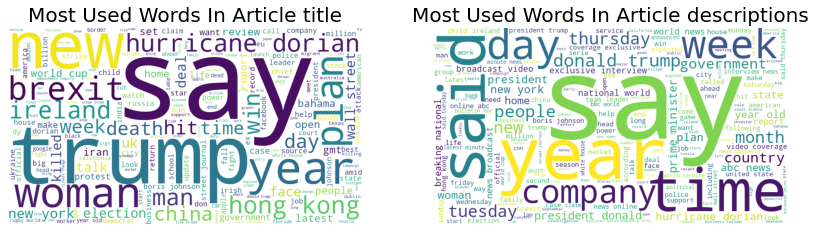

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[14,14])
wc1 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_title))
wc2 = WordCloud(width=900,height=500,stopwords=STOPWORDS, background_color = 'white').generate(' '.join(df.cleaned_description))
ax1.imshow(wc1)
ax2.imshow(wc2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title("Most Used Words In Article title",fontsize=20)
ax2.set_title("Most Used Words In Article descriptions",fontsize=20)
plt.show()

<a id='part4'></a>

## Part 4: Exploratory Analysis 
This section will focus on enriching the data set at hand by applying a range of models to it. The goal is to see if we can create attributes from the text and image data that will help the engagement prediction. Specifically, sentiment analysis and topic modelling are applied to the textual content of articles. For the image attribute a HSV analysis will be done at the end of this section.

<a id='part41'></a>
### Part 4.1 Sentiment and Subjectivity Analysis 


After having gone through some desciptive statistics of the article data set, more complex analysis can now be carried out. This is here done by looking into the text of the articles. Analyzing language is called Natural Language Processing (NLP) and contains a variety of topics - some of them are sentiment and subjectivity analysis which is covered in this section. 

The analysis have two main goals. Firstly, to provide sentiment and subjectivity scores in order to see, whether or not these can explain the engagement for articles and secondly to be a tool for getting better insight of the data. The tool used is [TextBlob](https://textblob.readthedocs.io/en/dev/), which is a library for processing textual data. It provides an API for diving into NLP tasks such as the ones used in this section.

The sentiment tool gives a result between -1 and 1, where -1 implies that the article is written in a very negative language, 0 implies neutral language and a score of 1 implies very positive language. The subjectivity tool provides a score between 0 and 1, where 0 is very objective and 1 very subjective language.

Even before carrying out the analysis one should assume that most articles are written in a neutral and objective language, however it is still interesting to see whether or not this assumption actually holds, and if there is any difference between the language of the different publishers.

In [20]:
from textblob import TextBlob
# function to calculate subjectivity
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity
    # function to calculate polarity
def getPolarity(review):
    return TextBlob(review).sentiment.polarity

# functions to label the articles
def analysis_sent(score):
    if score >= 0.5:
        return 'Positive'
    elif score <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'

def analysis_subj(score):
    if score >= 0.5:
        return 'Subjective'
    else:
        return 'Objective'

In [21]:
#Creating columns for sentiment and subjectivity
df['subjectivityScore'] = df['cleaned_description'].apply(getSubjectivity)
df['polarityScore'] = df['cleaned_description'].apply(getPolarity)
df['polarity'] = df['cleaned_description'].apply(getPolarity).apply(analysis_sent)
df['subjectivity'] = df['cleaned_description'].apply(getSubjectivity).apply(analysis_subj)

In [22]:
#slicing dataframe
positive_art=df[df['polarity']=='Positive']
neutral_art=df[df['polarity']=='Neutral']
negative_art=df[df['polarity']=='Negative']
subj=df[df['subjectivity']=='Subjective']
obj=df[df['subjectivity']=='Objective']

#saving counts for ploting and printing
print("Total number of articles:", len(df))
count_neg=len(negative_art)
count_neu=len(neutral_art)
count_pos=len(positive_art)
count_subj=len(subj)
count_obj=len(obj)
print("Number of negative articles:", count_neg)
print("Number of neutral articles:", count_neu)
print("Number of positive articles:", count_pos)
print("Number of subjective articles:", count_subj)
print("Number of objective articles:", count_obj)

Total number of articles: 8720
Number of negative articles: 172
Number of neutral articles: 8082
Number of positive articles: 466
Number of subjective articles: 2437
Number of objective articles: 6283


The figure below shows the distribution of the sentiment scores. Clearly, the assumption of neutral language holds for the most part. However, more than 5% of the articles are classified as positive and the histogram on the right shows, that there are articles placed in every single bin - implying that there are both articles with very negative and positive language in the data set. 

In [23]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','gold','indianred'] #Setting the color
labels = 'Positive', 'Neutral', 'Negative' #Setting the labels
values = [count_pos, count_neu, count_neg] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(negative)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Negative']['polarityScore'],
                           name="Negative",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(positive)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Positive']['polarityScore'],
                           name="Positive",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(neutral)
fig.add_trace(go.Histogram(x=df.loc[df['polarity']=='Neutral']['polarityScore'],
                           name="Neutral",marker=dict(color="gold"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Sentiment distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

The chart below shows the distribution of positive, negative and neutral articles in percentage of the total amount of articles published by each source. Interesting to see is that some publishers clearly writes in a more neutral language than others. The most neutral being Reuters with $<$2% positive and $<$1% negative articles. At the other extreme BBC News have more than 12% of their articles classified as using positive language and 2.7% as negative.

In [24]:
grouped_count=df.groupby(['source_name','polarity']).count().reset_index()
grouped_count=grouped_count[['source_name','polarity','description']] 
grouped_count['description'] = grouped_count['description'] / grouped_count.groupby('source_name')['description'].transform('sum')*100
grouped_count#Plotting

fig = px.bar(grouped_count, x="source_name", y="description", color="polarity", title="Sentiment distribution per publisher",
             labels={'description':'%','source_name':'Publisher','polarity':''}, color_discrete_map={
        'Positive': 'forestgreen',
        'Neutral': 'gold','Negative': 'indianred'})
for data in fig.data:
    data["width"] = 0.6 #Change this value for bar widths

fig.update_layout(hovermode="x unified", legend=dict(
        x=1.0,
        y=0.5,        
    ))

config = {'displayModeBar': False}
fig.show(config=config)

The next chart shows the distribution of subjectivity scores. Again, the assumption of objective language in articles hold for the most part, but actually $\sim$28% of the articles are classified as using subjective language. Important to note is that the threshold is set at 0.5, meaning that not all of the "subjective" articles are very subjective - this can also be seen in the histogram on the right 

In [25]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "histogram"}]]) #Making two plots

colors=['forestgreen','indianred'] #Setting the color
labels = 'Objective', 'Subjective' #Setting the labels
values = [count_obj, count_subj] #Stating the values for the pie plot

#Plotting the pie plot
fig.add_trace(go.Pie(labels=labels, values=values,name="",showlegend=False,
                     marker=dict(colors=colors,line=dict(color='#ffffff', width=6))),
     row=1, col=1)


#Plotting the histogram(Subjective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Subjective']['subjectivityScore'],
                           name="Subjective",marker=dict(color="indianred"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
#Plotting the histogram(Objective)
fig.add_trace(go.Histogram(x=df.loc[df['subjectivity']=='Objective']['subjectivityScore'],
                           name="Objective",marker=dict(color="forestgreen"),xbins=dict(
        start=-1.0,
        end=1,
        size=0.1)),row=1, col=2)
fig.update_layout(hovermode="x unified",title_text='Subjecivity distribution ',title_x=0.5) # title of plot)

config = {'displayModeBar': False}

fig.show(config=config)

To end this section, the average subjectivity score is shown for each publisher. Here it can be seen that all of the sources on average would be classified as using objective language as the average scores are below 0.5. Most of them are scored somwhere between 0.27 and 0.36 with only Business Insider being significantly more subjective on average and ABC News and Al Jazeera English being more objective on average.

In [26]:
source_plot = df.groupby('source_name').subjectivityScore.mean().sort_values(ascending=False)

fig = px.bar(x=source_plot.index, y = source_plot.values, height=500, width=800)
fig.update_xaxes(title_text='Publisher')
fig.update_yaxes(title_text='Avg. subjectivity score')
fig.update_xaxes(type='category')
fig.update_layout(hovermode="x unified",title = 'Avg. subjectivity score per publisher')
fig.show()

<a id='part42'></a>

### Part 4.2: Topic modelling

This section aims to investigate how the text content of the articles best can be divided into topics. This is done for two main reasons. Firstly, as the goal of this study is to predict the engagement, it could seem likely that the topic of an article have an influence on the popularity of it. Secondly, it can serve as a descriptive tool to better understand, what was the main topics in the article during the time of the data set.

The study will use [Latent DirichletAllocation (LDA)](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158) to perform topic modeling on the data. It consists of two main parts; generating topics and assigning topics to the articles. Each of the articles will then be able to be described by a distribution of topics and each of the topics are described by a distribution of words. To do this analysis, an article's description will be used and more specifically, the cleaned version made in the Data Cleaning section. This is done as the model input only should contain meaningfull words in order to reduce noise - as for the sentiment analysis. 

At last, the input to the model is a collection of all the descriptions of articles - namely the 'corpus'. The topic model is first implemented to generate topics and label each article with the most appropriate topic. The model determines the optimal number of topics to represent the lyrics corpus based on a measure of [coherence](https://radimrehurek.com/gensim/models/coherencemodel.html). It should be noted that the LDA usually initializes with random variables and thus it could generate slightly different topics every time if a seed is not set.

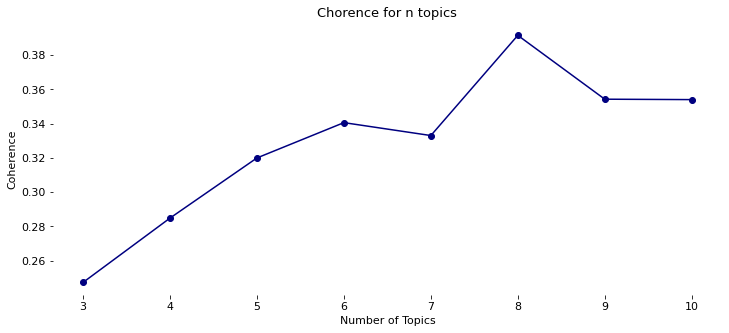

In [27]:
#Prepping model inputs
corpus = df['cleaned_description'].values.tolist()
tok_corp= [word_tokenize(sent) for sent in corpus]
lexi = corpora.Dictionary(tok_corp)
corpus = [lexi.doc2bow(d) for d in tok_corp]

plt.figure(figsize=(12, 5))

#Choose n parameter based on coherence measure
coherence_vals = []
for k in range(3,11):
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k,id2word = lexi, eval_every=None,passes=3,
               iterations=5,chunksize=100,random_state=123)

    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=tok_corp, dictionary=lexi, coherence='c_v')   

    coherence_vals.append((k,cm.get_coherence()))

n_topics = [x[0] for x in coherence_vals]
coherence = [x[1] for x in coherence_vals]

plt.plot(n_topics,coherence,color='navy')
plt.scatter(n_topics,coherence,color='navy')
plt.xlabel('Number of Topics',fontsize=11,color='black')
plt.ylabel('Coherence', fontsize=11,color='black')
plt.xticks(n_topics,fontsize=11,color='black')
plt.yticks(fontsize=11,color='black')
plt.title('Chorence for n topics',fontsize=13,color='black')
plt.box(False)

#plt.show()

From the coherence measure the optimal number of topics is $n=8$. Again, with the reservation that this is only run for 3 to 10 topics and that it can change due to the randomness of the model.

In [28]:
#Running the LDA model with the optimal number of topics found above
n_sub_topics= 3+coherence.index(max(coherence))
lda = LdaModel(corpus=corpus, id2word=lexi, iterations=5,chunksize=100, passes=3,num_topics=n_sub_topics, 
          update_every=1, alpha='auto', random_state=123,eval_every=None)

In [29]:
#Finding the topics 
topic_data =  pyLDAvis.gensim_models.prepare(lda, corpus, lexi, mds = 'pcoa')
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
lambd = 0.8# Adjust this accordingly based on tuning above
for i in range(1,n_sub_topics+1): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
    topic_df = pd.DataFrame(all_topics).T
#Display keywords that represents each topic
topic_df

0         1          2            3        4             5  \
Topic 1        say      week  wednesday         said    woman      minister   
Topic 2       said  thursday      china      company    stock       ukraine   
Topic 3       year       old       just       target     case  investigates   
Topic 4  president     trump      state       donald  officer          hour   
Topic 5        new      time    million         york     city       inquiry   
Topic 6     police    people        day         like      joe         biden   
Topic 7      story  business      house  impeachment      way      investor   
Topic 8       news     world   national        video   online     interview   

                6         7          8         9  
Topic 1    report     prime     latest  european  
Topic 2     month     trade     market   country  
Topic 3   october    killer         th    health  
Topic 4      home      read       dead     photo  
Topic 5       son     start    quarter    season  
Topic 6   morning      life     killed      open  
Topic 7      deal      told      phone      want  
Topic 8  coverage  breaking  exclusive       abc

The 8 topics and their 10 most key words are shown above in the table. Safe to say that many of the topics somewhat related to politics. In topic 1 there are words such as *Prime* and *Minister*, topic 4 is related to *President Donald Trump* and Topic 6 contains *Joe Bidens* name. Then there is topic 3 which seems to be about crime cases containing words as *Case*, *Invastigates* and *Killer*, and a *Breaking News* topic in topic 8.

The performance of the LDA can be examined further by used the interactive visualizer as shown below. Here the topics are shown in a 2D space on he left and the chart on the right shows the words that describes the given topic. This bar chart on the right is linked to the tunable $\lambda$-parameter which is based on the TF-IDF. A high $\lambda$-value gives more importance to the term frequency and vice versa.

In [30]:
pyLDAvis.display(topic_data)

The articles are now assigned to the different topics. With this it is possible to look at the relevance of topics in the context of engangement prediction a little later.

In [31]:
train_vecs = []
for i in range(len(df)):
    top_topics = lda.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(3+coherence.index(max(coherence)))]
    train_vecs.append(topic_vec)

In [32]:
topics = pd.DataFrame(train_vecs,columns = ['topic1','topic2','topic3','topic4','topic5','topic6','topic7','topic8'])
df = pd.concat([df, topics], axis=1)

<a id='part43'></a>

### Part 4.3: HSV Image Analysis

This section reads the image urls and explores the colors of the images in the articles. This is done to explore whether a simple measurement of an article's image can help explain the engagement. The analysis is based on [HSV](https://realpython.com/python-opencv-color-spaces/) colors, which stands for the Hue, Saturation and Value (brightness) of an image. This color space is partifularly useful for identifying contrasts in images.

The following function process an image and finds the HSV colors by using the `cv2` package. Finally it takes the mean value of the HSV colors for each image.

In [33]:
#function to process one image
def process_image(url):
    res = requests.get(url) # get image url
    im = imageio.imread((res.content)) # read image url

    #getting the HSV colors
    hue_mean, sat_mean, bright_mean = cv2.mean(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))    
    
    #return mean HSV values
    return hue_mean,sat_mean,bright_mean

In [ ]:
'''
df[['img_hue', 'img_sat', 'img_val']] = np.nan
'''

#WARNING: This code has a very long runtime. The output data has been saved in a new csv. So download this instead.
'''
for i in range(len(df)): # Loop through every article
    hue_mean,sat_mean,bright_mean = process_image(url)
    df["img_hue"][i], df["img_sat"][i], df["img_val"][i] = hue_mean,sat_mean,bright_mean

In [34]:
hsv = pd.read_csv("df_hsv.csv", index_col=0)
hsv = hsv[['img_hue','img_sat','img_val']]
df = pd.concat([df,hsv], axis=1)

Let's check if the found HSV values makes sense, by printing the images with the highest and lowest values.

In [35]:
print("Row with highest Saturation:", df['img_sat'].idxmax())
print("Row with highest Brightness:", df['img_val'].idxmax())
print("--------------------------------------------")
print("Row with lowest Saturation:", df['img_sat'].idxmin())
print("Row with lowest Brightness:", df['img_val'].idxmin())

Row with highest Saturation: 1650
Row with highest Brightness: 527
--------------------------------------------
Row with lowest Saturation: 14
Row with lowest Brightness: 3593


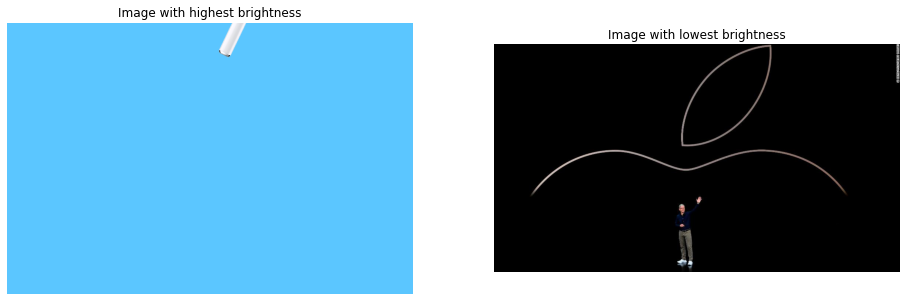

In [36]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_val'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_val'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest brightness')
ax[1].set_title('Image with lowest brightness')
plt.show()

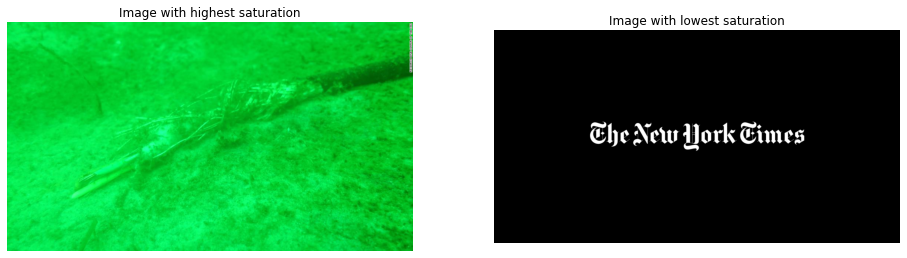

In [37]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].imshow(imageio.imread(df.iloc[df['img_sat'].idxmax()].url_to_image))
ax[1].imshow(imageio.imread(df.iloc[df['img_sat'].idxmin()].url_to_image))
ax[0].axis('off')
ax[1].axis('off')

ax[0].set_title('Image with highest saturation')
ax[1].set_title('Image with lowest saturation')
plt.show()

The extracted HSV colors of the images is assumed to be accurate as the lowest and highest values of brightness and saturation revealed the expected result.

In [38]:
#df.to_csv('df_all_attributes.csv')

<a id='part5'></a>

## Part 5: Preparation for Prediction

The data has now been cleaned, analysed and expanded with new attributes. This section seeks to prepare the data for the prediction models which will be shown in the next section. To begin, it is relevant to see, if any of our attributes have a significant correlation with the total engagement.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8720 entries, 0 to 8719
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   source_name          8720 non-null   object 
 1   title                8720 non-null   object 
 2   cleaned_title        8720 non-null   object 
 3   description          8720 non-null   object 
 4   cleaned_description  8720 non-null   object 
 5   url_to_image         8720 non-null   object 
 6   top_article          8720 non-null   float64
 7   engagement           8720 non-null   float64
 8   engagement_log       8720 non-null   float64
 9   Date                 8720 non-null   object 
 10  Date.1               8720 non-null   object 
 11  Hour                 8720 non-null   float64
 12  Day_Of_Week          8720 non-null   float64
 13  Continent            8720 non-null   object 
 14  filepath             8720 non-null   object 
 15  subjectivityScore    8720 non-null   f

In [41]:
df = pd.read_csv('df_all_attributes.csv',index_col = 0, keep_default_na=False)

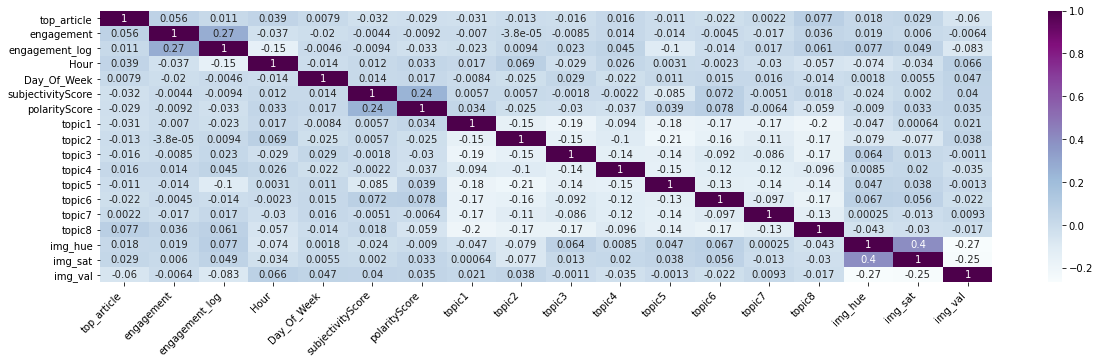

In [42]:
g = sns.heatmap(df.corr(), cmap="BuPu", annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation = 45, horizontalalignment = 'right')
plt.show()

From the correlation plot above, it can be concluded, that the `engagement` has very low correlation with all other attributes. The highest correlation is 0.056 with the attribute `top_article`, which is not included in the models for reasons previously explained. However, even this correlation is so small that it cannot be said to be significant. Note that all the added attributes (from subjectivity score and onwards) also have close to no correlation with `engagement`. This indicates a simple model cannot perform well on this data and is the reason why more complex models are proposed in the next section.

It is worth mentioning that the particular publisher was found to have a lot to do with the amount of engagement in Part 3: Descriptive Statistics. These are not shown is this correlation heatmap as dummy-variables need to be created, but this will be included later on.

To evaluate the generalization error of our models we need to split the data. We split it into a train (72%), validation (8%) and test (20%) set.

In [44]:
y = np.array(df[['engagement','engagement_log']])
X = np.array(df[['source_name','title','cleaned_title','description','cleaned_description', 
                 'url_to_image','filepath','polarityScore','subjectivityScore']])
X_par, X_test, y_par, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_par, y_par, test_size=0.10, random_state=42)

In [45]:
X_train=pd.DataFrame(X_train, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                       'polarityScore','subjectivityScore'])
X_val=pd.DataFrame(X_val, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                   'polarityScore','subjectivityScore'])
X_test=pd.DataFrame(X_test, columns=['source_name','title','cleaned_title','description','cleaned_description','url_to_image','filepath',
                                     'polarityScore','subjectivityScore'])

y_train = pd.DataFrame(y_train, columns=['engagement','engagement_log'])
y_val = pd.DataFrame(y_val, columns=['engagement','engagement_log'])
y_test = pd.DataFrame(y_test, columns=['engagement','engagement_log'])

In [46]:
pickle.dump(X_train, open("X_train.p", "wb"))
pickle.dump(y_train, open("y_train.p", "wb"))
pickle.dump(X_val, open("X_val.p", "wb"))
pickle.dump(y_val, open("y_val.p", "wb"))
pickle.dump(X_test, open("X_test.p", "wb"))
pickle.dump(y_test, open("y_test.p", "wb"))

<a id='part6'></a>

## Part 6: Prediction Models

Based on the findings in the descriptive and exploratory analysis it has become clear, that it is not trivial to predict the total engagement of articles from the attributes available so far. In this section we therefore propose more complex modelling approaches. Specifically we propose content-based approaches based on different neural network architectures. One is a convolutional neural network which is designed for working with image data. The second model is a pre-trained neural net for NLP problems from Google AI Language called BERT.  The third model is a combination of the first two. This is created to best simulate the human behaviour when scrolling through Facebook. Here it is assumed that the way we interact with articles is based on the overall impression from both the text content and the picture of the articles.

The models used in this section is compared to both a simple baseline model, which always predicts the the mean value of the engagement in the training data. Moreover, when researching for previous work with this data set, we found that this [article](https://towardsdatascience.com/analyzing-and-predicting-consumer-engagement-8b3229f0cbad) explores the exact same problem. Consequently, it is possible to benchmark the models proposed in this project to the method used in this article too. 

First, the training, validation and test data is loaded.

In [2]:
X_train = pickle.load(open("X_train.p", "rb"))
X_val =  pickle.load(open("X_val.p", "rb"))
X_test =  pickle.load(open("X_test.p", "rb"))
y_train = pickle.load(open("y_train.p", "rb"))
y_val = pickle.load(open("y_val.p", "rb"))
y_test = pickle.load(open("y_test.p", "rb"))

In [3]:
def evaluate(pred, labels):
  MSE = mean_squared_error(y_true = labels, y_pred = pred)
  r2 = r2_score(y_true = labels, y_pred = pred)
  MAE = mean_absolute_error(y_true = labels, y_pred = pred)
  RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

  return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

<a id='part61'></a>

### 6.1 Baseline (mean)

This section presents the simple baseline model. The performance metric we use to compare the models will be the RMSE (Root Mean Squarred Error). Note that for all models predictions are made in the log-domain, and thus the RMSE scores should be viewed bearing this in mind.

In [4]:
X_train_baseline = pd.concat([X_train,X_val], axis = 0)
y_train_baseline = pd.concat([y_train,y_val], axis = 0)

In [5]:
y_pred = np.mean(y_train_baseline['engagement_log'])
y_pred = np.array([y_pred]*len(y_test))

In [6]:
print("RMSE: ",round(np.sqrt(mean_squared_error(y_pred,y_test['engagement_log'])),2))

RMSE:  2.65


<a id='part62'></a>

### 6.2 Light GBM regressor

In the previous work done with this problem shown in the [article](https://towardsdatascience.com/analyzing-and-predicting-consumer-engagement-8b3229f0cbad), a LGBM (Light Gradient Boosting Machine) regressor is used. This method is based on decision tree algorithms. The implementation below is a copy of what is shown in the article and can be validated by the fact, that we get the exact same RMSE score as in the article. As input the LGBM regressor takes the TF-IDF vectors of the data points and from this makes the engagement prediction.

In [7]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2),
                            dtype=np.float32, 
                            sublinear_tf=True, 
                            use_idf=True, 
                            smooth_idf=True)
train_tfidf = tfidf_vec.fit_transform(X_train_baseline['cleaned_description'])
test_tfidf = tfidf_vec.transform(X_test['cleaned_description'])

In [8]:
model1 = LGBMRegressor(verbose=-1,
                       learning_rate=0.01,
                       max_depth=20,
                       num_leaves=50,
                       n_estimators=150)

In [9]:
model1.fit(train_tfidf,y_train_baseline['engagement_log'])
pred1 = model1.predict(test_tfidf)
print("RMSE: ",round(np.sqrt(mean_squared_error(pred1,y_test['engagement_log'])),2))

RMSE:  2.57


With the RMSE score of 2.57, this is an improvement from the simple baseline model. However, due to the rather small improvement, this underlines the difficulty of this prediction problem.

<a id='part63'></a>


### 6.3 Convolutional neural networks (CNNs)

Source: [TensorFlow 2.x in the Colaboratory Cloud](https://link-springer-com.proxy.findit.cvt.dk/content/pdf/10.1007/978-1-4842-6649-6.pdf)  

**Introduction to CNN**  
Convolutional neural networks (CNNs) are a specialized type of neural network models designed for working with two-dimensional image data. In a CNN an image is processed by assigning importance to various elements in it, which enables it to differentiate between images. The core building block of CNN is the convolutional layer. Such a layer contains a series of filters that transform an input image by extracting features into feature maps. This is done by sliding the kernel (the kernel is a matrix)  of a specific "window" size over the input image. Each filter is a different matrix and it is therefore repeated for each filter. As this is done the new feature map is then fed to the next layer in the network. 
Hence, a feature map captures the result of applying a convolutional layer.


**Implementation of CNN**

The input for the CNN is an image, with 3 channels, namely the RGB colors. 

The CNN consists of multiple layers. In the implementation of the CNN several convolutional layers will be applied together with pooling layers. The reason for having e.g. two convolutional layers is that the first layer will investigate low level features as edges and corners whereas the next layer will extract higher level features such as nose, ears eyes. The pooling layers shrinks the input size of the image to reduce the computation, which also helps limting the risk of overfitting. In this implementation of CNN a max pooling will be used. Max pooling takes the maximum input of a convolved feature map. As the CNN is spatial the correlation of the pixels location will not get lost by applying a pooling as it captures the most important features. Furthermore, the CNN is build with a ReLU (rectified linear unit) activation function, which ensures nonlinearity and maintains the dimensionality. Finally, a global max pooling layer is applied in order to reduce the dimensions from 3D to 1D. Mostly the CNN is used for classification but in this case this model will be used to perform a regression and predict the article engagement from the images. 

- ```kernel_size``` - This is the size of the filter. In the first convolutional layer a kernel with size 5 x 5 is used. In the second convolutional layer a kernel with size 3 x 3 is used. The larger a kernel size the less computational costly it is. When choosing the kernel size 2x2 and 4x4 are generally not preferred because odd-sized filters symmetrically divide the previous layer pixels around the output pixel

- ```activation function``` - in our model ReLU is used as activation function which secures non-linearity and prevents the emergence of the “vanishing gradient” problem.

- ```filters``` - In the first convolutional layer 32 filters are used. In the second convolutional layer 64 filters are used. The first layer will therefore provide 32 feature maps and the second 64 feature maps. Each specific filter is able to extract different features. The reason for increasing the number of filters in our model, from the first convolutional layer to the second convolutional layer, is due to the fact that the patterns get more complex, thus there are larger combinations of patterns to capture.

- ```batch_size``` - Calculating gradients over all the data is usually time-consuming. That's why the training data is usually divided into chunks called "mini-batches". Although the gradients, in this case, become approximate, on practice, it even helps to get better solutions, for example, by escaping from local minima of the loss function.

- ```output layer``` - For regression a linear activation function is used. 

The CNN will be implemented using `Keras`.

The model will be trained using the ```fit()``` function. Some parameters to specify:
- ```epochs``` - Number of epochs to be used. One epoch corresponds to one pass through the whole train data. If ```batch_size=len(x_train)```, then one batch corresponds to one epoch.
- ```validation_data``` - The data to be used not for the test purposes on-the-fly (to detect overfitting).

In [ ]:
# Defining training, validation and test dataframes
train_df = pd.DataFrame({'filepath': X_train['filepath'], 'engagement_log': y_train['engagement_log']})
val_df = pd.DataFrame({'filepath': X_val['filepath'], 'engagement_log': y_val['engagement_log']})
test_df = pd.DataFrame({'filepath': X_test['filepath'], 'engagement_log': y_test['engagement_log']})

In [ ]:
# Normalizing pixel values from [0, 255] to [0, 1]
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df, # Training set
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df, # Validation set
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False,
    seed=42)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df, # Test set 
    x_col='filepath', # Independent variable
    y_col='engagement_log', # Dependent variable
    target_size=(120, 120), # Resizing images, total of 14,400 pixels in each picture
    color_mode='rgb', # Using RGB colors, three channels
    class_mode='raw',
    batch_size=32,
    shuffle=False)

Found 6278 validated image filenames.
Found 698 validated image filenames.
Found 1744 validated image filenames.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3)) # 120x120 images with 3 layers/channels (RGB colors)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs) # First convolutional layer
x = tf.keras.layers.MaxPool2D()(x) # First pooling layer, data is 3D
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x) # Second convolutional layer 
x = tf.keras.layers.MaxPool2D()(x) # Second pooling layer, data is 3D
x = tf.keras.layers.GlobalMaxPooling2D()(x) # Final pooling layers, that transforms the data to be 1D
x = tf.keras.layers.Dense(64, activation='relu')(x) # Dense layer
outputs = tf.keras.layers.Dense(1, activation='linear')(x) # Output layer

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='mse') # Mean squared error

In [9]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)])

Epoch 1/100
197/197 [==============================] - 2029s 10s/step - loss: 7.6412 - val_loss: 7.1419
Epoch 2/100
197/197 [==============================] - 126s 640ms/step - loss: 7.0580 - val_loss: 6.7973
Epoch 3/100
197/197 [==============================] - 124s 631ms/step - loss: 6.9250 - val_loss: 6.7487
Epoch 4/100
197/197 [==============================] - 124s 630ms/step - loss: 6.8876 - val_loss: 6.7010
Epoch 5/100
197/197 [==============================] - 124s 630ms/step - loss: 6.7983 - val_loss: 6.8237
Epoch 6/100
197/197 [==============================] - 124s 630ms/step - loss: 6.7997 - val_loss: 6.6146
Epoch 7/100
197/197 [==============================] - 134s 682ms/step - loss: 6.7235 - val_loss: 6.6486
Epoch 8/100
197/197 [==============================] - 126s 640ms/step - loss: 6.6424 - val_loss: 6.6608
Epoch 9/100
197/197 [==============================] - 125s 633ms/step - loss: 6.6298 - val_loss: 6.6389
Epoch 10/100
197/197 [==============================] - 

From running the epochs and visualising the train and validation loss it can be seen that the model runs 11 epochs which is due to the model not improving since epoch 6. 
Furthermore, we see how the training loss and validation loss decreases. After epoch 6 the validition loss starts to increase, which is an indication of overfitting. 

In [3]:
#model.save("drive/MyDrive/ABA project/CNN_regression_new.pb")
model = keras.models.load_model('CNN_regression.pb')

In [11]:
#Saving the history information
#pickle.dump(history.history, open("drive/MyDrive/ABA project/cnn_regression_new.pickle","wb"))

In [4]:
#The opens the pickle
history_regression = np.load("cnn_regression.pickle", allow_pickle=True)

In [ ]:
y_pred = np.squeeze(model.predict(test_images))
y_true = test_images.labels

In [23]:
evaluate((y_pred), (y_true))

{'mae': 2.107521480725543,
 'mse': 6.542539824259159,
 'r2': 0.070172921812508,
 'rmse': 2.5578388972449297}

In conclusion, when comparing the $RMSE=2.56$ score to the baseline models, the CNN clearly outperforms the simple baseline and slightly outperforms the LGBM regressor. It is interesting that only looking at pictures from the articles, we are able to predict as well as the LGBM which focuses on the textual content. However, the model performance is still not great. This could be due to the pictures in the data set being so different and therefore the model can have difficulties detecting patterns. From resizing the images some information is also lost.
Furthermore, CNN's are mostly used for classification.

In [14]:
epochs = range(21)
loss = history_regression['loss']
val_loss = history_regression['val_loss']

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(epochs), y=loss, mode='lines', name='training loss'))
fig.add_trace(go.Scatter(x=np.array(epochs), y=val_loss, mode='lines', name='validation loss'))
fig.update_layout(title='Training and validation loss, CNN regression',
                   xaxis_title='epoch',
                   yaxis_title='mse')
fig.show()

<a id='part64'></a>

### 6.4 BERT model



**Introduction to BERT model**

Another way to model the engagement count using the text, is to use a more sophisticated method than the lightGBM approach used earlier. One hypothesis may be that the semantic meaning and the order of the words is better at explaining the facebook engagement of an article. To model this we have used the NLP model called Bi-Directional Encoder Representations from Transformers (BERT) model. The model relies heavily on the "Transformer" architecture, which was introduced in the now infamous article, ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762). The reason why we have chosen BERT instead of implementing an RNN is because the transformer architecture, that BERT utilizes, more or less has substituted LSTM and other recurrent neural network based models for NLP tasks. The main advantage of the transformer is that it allows faster training through parallelization, avoidance of the vanishing gradient problem, and enables transfer learning to a higher degree than before. There exists dozens of NLP models using the transformer architecture and we chose BERT because it has a proven track-record for a variety of tasks including regression, sentiment analysis, question answering, summarization and text generation.

The transformer architecture of BERT allows for transfer-learning, thus a highly sophisticated pre-trained model can be downloaded and fine-tuned for the specific task in hand. In fact, the BERT model was pre-trained on 3.3 billion words (from wikipedia and Google's BooksCorpus) for 4 days in an unsupervised manner that has ensured that the transformer layers (110 million parameters) of the model has "learnt" the english language and the "spoken" world we live in. The transformer layers are the engine of the model and to accomodate the regression problem we add a dense layer that connects the output of the transformer layers to a single neuron which acts as our prediction.


To make a prediction, an input sentence (sequence of tokens) is fed to the model, and along with the token is a positional encoding. The positional encoding allows the model to interpret the correct meaning of a sentence accounting for the semantics of the words and also the context of the words - just as humans do - contrary to the tf-idf principle where the uniqueness and popularity of the words are the only sources of information. This information is passed through the model's 12 transformer layers which accomodates pattern recognisition in highly latent dimensions. Finally, it is sent through the added dense layer and a prediction is obtained. Below is a figure that shows the main components of the model. Notice that the output of the BERT component is a 768 long vector.







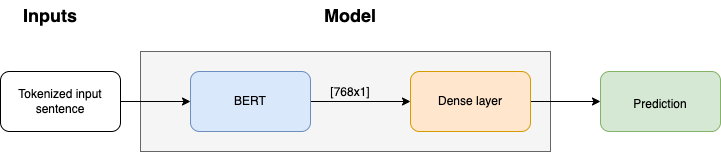

**Implementation of BERT model**

To facilite the fine-tuning of the BERT model, the huggingface API has been used (www.huggingface.co). It is a platform created for cooperation and sharing of NLP models and datasets. As the fine-tuning of the BERT model is cumbersome (as it is recommended to fine-tune all 110 million parameters in transformer models), the training has been done using one of Colabs GPU's for speed enhancement. This means that the below cells are mostly copied from Colab, and thus not run in this local notebook. However, as the training is a central part it is included below. We install the required packages, here among the transformers (the huggingface api) and wandb (similar to TensorBoard). Next we load the tokenizer and the model of interest from the huggingface api, tokenize the data and create a custom dataset class (required by PyTorch framework). For the training of the model we take advantage of the Trainer argument that comes with the huggingface library, hence, we define the training arguments, evaluation metrics and finally the trainer object. The model is now easily trained.

To ensure that we do not overfit (which the model is very prone to), we use a validation set and use the *EarlyStoppingCallback*, which ensures that the training stops if we haven't improved the performance of the validation set in a while. A simple tuning of the hyperparameters of the training loop has been executed and the following hyperparameters were chosen. A learning rate of 5e-5 (default value), a batch_size of 16 and evaluation steps of 100. 


In [ ]:
!pip3 install transformers==4.8.2
!pip install wandb

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,RobertaForSequenceClassification, RobertaTokenizer
from transformers import EarlyStoppingCallback

The data is loaded from the pickles. In the input, X, we use both the title and description, as both may contain information valuable for the model.

In [ ]:
X_train = pickle.load(open("drive/MyDrive/ABA project/X_train.p", "rb"))
X_val =  pickle.load(open("drive/MyDrive/ABA project/X_val.p", "rb"))
X_test =  pickle.load(open("drive/MyDrive/ABA project/X_test.p", "rb"))
y_train = pickle.load(open("drive/MyDrive/ABA project/y_train.p", "rb"))
y_val = pickle.load(open("drive/MyDrive/ABA project/y_val.p", "rb"))
y_test = pickle.load(open("drive/MyDrive/ABA project/y_test.p", "rb"))

X_train = list(X_train['title'] + X_train['description'])
X_val = list(X_val['title'] + X_val['description'])
X_test = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

In [ ]:
#download the pre-trained model and tokenizer from the huggingface api. 
#Note that we download the model from BertForSequenceClassification, which may seem odd, but as we indicate
#that we only have one label the model in fact contains a regression layer on top.
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=1)

In [ ]:
#The data is tokenized. We use a max_length of 128 tokens, which ensures that all words for all sentences are
#fed to the model.

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=128)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=128)

In [ ]:
# Create torch dataset.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

#create dataset objects
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [ ]:
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters

def compute_metrics_reg(p):
    pred, labels = p

    MSE = mean_squared_error(y_true = labels, y_pred = pred)
    r2 = r2_score(y_true = labels, y_pred = pred)
    MAE = mean_absolute_error(y_true = labels, y_pred = pred)
    RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

    return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

# Define Trainer
args = TrainingArguments(
    output_dir="Bert",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps = 100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    learning_rate = 5e-5,
    load_best_model_at_end=True,
    report_to="wandb"
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

PyTorch: setting up devices


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-100
Configuration saved in Bert/checkpoint-100/config.json
Model weights saved in Bert/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-200
Configuration saved in Bert/checkpoint-200/config.json
Model weights saved in Bert/checkpoint-200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-300
Configuration saved in Bert/checkpoint-300/config.json
Model weights saved in Bert/checkpoint-300/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to Bert/checkpoint-400
Configuration saved in Bert/checkpoint-400/config.json
Model weights saved in Bert/checkpoint-400/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 698
  Batch size = 1

TrainOutput(global_step=1000, training_loss=5.51501235961914, metrics={'train_runtime': 431.0396, 'train_samples_per_second': 436.944, 'train_steps_per_second': 27.352, 'total_flos': 1301656631962080.0, 'train_loss': 5.51501235961914, 'epoch': 2.54})

The above log shows how the model learns. The training and validation loss (MSE) is shown for each evaluation step along with the RMSE, R2 and MAE scores. As the training loss decreases, it is evident that the model is able to learn some patterns in the training set. However, the question is whether the model learns general patterns or simply just utilizes its large amount of parameters to memorize the training data. Up until the 500th step the evaluation loss has decreased but after this step is starts to increase - this is a clear indication of overfitting. Therefore, to ensure the best generalization error, the model parameters from step 500 is used as the final model. Compared to other neural networks this is quite a steep/fast learning curve, which could have been slowed by a smaller learning rate. However, an attempt at doing this did not provide better results - thus the default learning rate was kept. We are now ready do to inference!

In [ ]:
# ----- 3. Predict -----#
# Load test data, create torch dataset, define test trainer and make prediction
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=128)
test_dataset = Dataset(X_test_tokenized)
test_trainer = Trainer(model)
y_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
#define evaluation function
def evaluate(pred, labels):
    MSE = mean_squared_error(y_true = labels, y_pred = pred)
    r2 = r2_score(y_true = labels, y_pred = pred)
    MAE = mean_absolute_error(y_true = labels, y_pred = pred)
    RMSE = mean_squared_error(y_true = labels, y_pred = pred, squared = False)

    return {"rmse": RMSE, "mse": MSE, "r2": r2, "mae": MAE}

In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9328157435774105,
 'mse': 5.817625617246185,
 'r2': 0.17319787498805883,
 'rmse': 2.411975459503306}

Above the evaluation scores on the test set along with a predicted vs true value plot is shown. 


The BERT model is to some extent able to predict the engagement of a facebook article. The RMSE is 2.37 and the R2 score is 0.2. Thus compared to the LightGBM model (and baseline) the BERT model is better able to predict the facebook engagement. Intuitively, this makes sense as the context of the words and the semantic meaning should yield extra information compared to the tf-idf.

**SKAL DER STÅ MERE?**

The model was uploaded to the huggingface library and can be found here https://huggingface.co/jenspt/bert_regression_basic_16_batch_size.

<a id='part95'></a>

### 6.5 BERT model with simple extension

In the descriptive analysis we saw that the engagement was correlated with the publisher. The big media houses such as CNN and The New York Times experienced a mean engagement count of 1000, whereas the Irish Times had a mean engagement count just above 0. Why don't we try to add this information to the previous model. As we will be extending the previous BERT model with this information, we need to modify the structure of the model to accomodate an extra input vector corresponding to the publisher of the article. As the publisher information is a categorical variable, one-hot-encoding is used, which leaves us with a boolean vector of length 12 (We have 12 different publishers). 



In [ ]:
#import dependencies
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss

#Load data from pickles
X_train_source = np.array(pd.get_dummies(X_train['source_name']))
X_val_source = np.array(pd.get_dummies(X_val['source_name']))
X_test_source = np.array(pd.get_dummies(X_test['source_name']))

X_train_text = list(X_train['title'] + X_train['description'])
X_val_text = list(X_val['title'] + X_val['description'])
X_test_text = list(X_test['title'] + X_test['description'])
y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

As we are creating a custom model, we this time need to create a class that extends the torch.nn.Module class. In this class we define the structure of our model, the forward pass and the loss function. 


In the inialization of the model, the pre-trained BERT model is downloaded without the dense layer for regression. A "custom" dense layer is specified where the input dimension is equal to that of the BERT output [768] + the publisher vector [12]. It is in this way that the publisher information is included in the model. A forward pass consists of the tokenized text input going through the BERT model. Afterwards the BERT output is concatenated with the publisher vector which is then sent through the regression dense layer. Thus, the publisher vector works as a bias term in the model. To avoid unnecessary overfitting, a dropout is used during training for the dense layer (and automatically also for the bert model). The loss is simply the mean squared error - similar to what we used in the previous model.

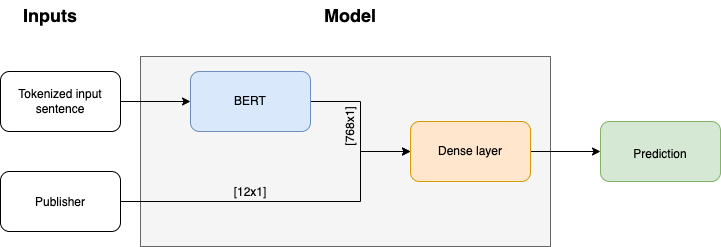

In [ ]:
#Custom model
class BertSource(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_Bert = 768
        D_in_source = 12 #different source_names
        D_out = 1

        #download "pure" BERT model from huggingface
        self.bert = BertModel.from_pretrained("bert-base-uncased")   


        #dense layer
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source, D_out) 

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
    ):

        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #from bert
        pooled_output = bert_outputs[1]
        pooled_output = self.dropout(pooled_output)
        

        #combined
        combined_output = torch.cat([pooled_output, source], dim = 1)

        logits = self.regressor(combined_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
            

        return (loss, logits)


In [ ]:
#init model
model = BertSource(drop_rate=0.2)

In [ ]:
#The dataset class now needs to handle the publisher data
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["source"] = torch.squeeze(torch.tensor(self.source[idx,:])) # add source_name to dataset
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, X_train_source, y_train)
val_dataset = Dataset(X_val_tokenized, X_val_source, y_val)

In [ ]:
#We define a new Trainer object using the new model
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
)

In [ ]:
# and we train again...
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to BERT_w_source/checkpoint-500
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evalua

TrainOutput(global_step=1200, training_loss=5.031382548014323, metrics={'train_runtime': 573.1771, 'train_samples_per_second': 328.59, 'train_steps_per_second': 20.57, 'total_flos': 0.0, 'train_loss': 5.031382548014323, 'epoch': 3.05})

The model again learns quickly and this time the best validation error is after 700 steps - equivalent to 1.5 epoch. From the validation loss it is clear that the training is stochastic due to using batches. In the steps from 100-700, the validation loss generally decreases but now and then it also increases. This indicates that the different batches of the training dataset pull the model in different directions.

In [ ]:
# ----- 3. Predict -----#
# Load test data
X_test_tokenized = tokenizer(X_test_text, padding=True, truncation=True, max_length=128)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized, X_test_source, y_test)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
y_pred_best, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9050843896626328,
 'mse': 5.6908150668099085,
 'r2': 0.19122021596920258,
 'rmse': 2.385542929148396}

We can see that the performance of the model has increased! We now have a RMSE of 2.38 and a R2 of 0.19. Still far from perfect but it shows that the model is able to learn the biases of the publishers.


<a id='part66'></a>

### 6.6 Combined CNN and BERT model!

So far we have tried to model the engagement based on the text and the images seperately. What if we combine the two models and thus try to make a super model that uses information from both the images and the text - exactly what us humans do when scrolling through facebook!


To do this we need to incorporate the images into the model and dataset classes. As the previous image CNN was implemented in Keras we need to reimplement it in PyTorch such that it is compatible with the above model. Furthermore, to accomodate transfer learning it was decided to add an extra dense layer with 10 neurons between the current convolutional layers and dense layer (conv2d -> dense (10) -> dense (1). When we do transfer learning we can then use the 10 neurons and concatenate it with the information from the text and the publisher. The 10 neurons can be interpreted as 10 different latent classes that an image can belong to. The image below shows the structure of the model. One may argue that the signals of the BERT model is overrepresented compared to the CNN (768 vs 10 input).









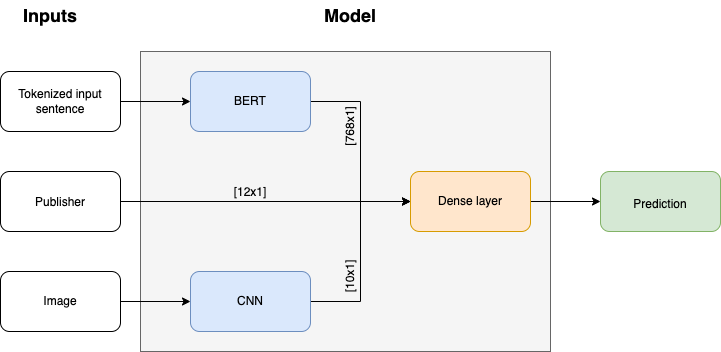

To ensure the best learning possibilities for the model, we need to firstly pre-train the basic CNN model on the dataset and afterwards fine-tune - just like what we do with the BERT model. The pre-training has been done with a learning rate of 0.001, whereas the fine-tuning is done with a learning rate of 5e-5. If we didn't have this difference we would in the fine-tuning phase alter the weights of the BERT model too much and essentially overfitting the model to the training data. The training of the basic CNN model can be found in the appendix but it can be said that we obtain similar results as in part 9.3.

To build this super model we need to define a new PyTorch model aswell as dataset class.

In [ ]:
from torchvision import transforms

In [ ]:
X_train_source = np.array(pd.get_dummies(X_train['source_name']))
X_val_source = np.array(pd.get_dummies(X_val['source_name']))
X_test_source = np.array(pd.get_dummies(X_test['source_name']))

X_train_image = np.array(X_train['filepath'])
X_val_image = np.array(X_val['filepath'])
X_test_image = np.array(X_test['filepath'])

X_train_text = list(X_train['title'] + X_train['description'])
X_val_text = list(X_val['title'] + X_val['description'])
X_test_text = list(X_test['title'] + X_test['description'])

y_train = list(np.log1p(y_train['engagement']))
y_val = list(np.log1p(y_val['engagement']))
y_test = list(np.log1p(y_test['engagement']))

In [ ]:
#Custom model
class SuperModel(nn.Module):
    def __init__(self, drop_rate=0.2):
        super().__init__()

        D_in_Bert = 768
        D_in_source = 12 #different source_names
        D_in_image = 10
        D_out = 1

        #bert
        self.bert = BertModel.from_pretrained("bert-base-uncased")
      


        #load pre-trained cnn and use all pre-trained layers but the last.
        image_full = torch.load("drive/MyDrive/ABA project/NN_models/image")
        self.conv1 = image_full.conv1
        self.conv2 = image_full.conv2
        self.l_1_image = image_full.l_1_image


        #final dense layer with 768 + 12 + 10 inputs.
        self.dropout = nn.Dropout(drop_rate)
        self.regressor = nn.Linear(D_in_Bert+D_in_source+ D_in_image, D_out)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        source=None,
        image=None,
    ):

        bert_outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        #from bert
        pooled_output = bert_outputs[1]
        pooled_output = self.dropout(pooled_output)

       
        #define CNN. Identical to the one implemented in Keras except the additional
        #dense layer
        x_image = image
        x_image = self.conv1(x_image)
        x_image = F.relu(x_image)
        x_image = F.max_pool2d(x_image,2)
        x_image = self.conv2(x_image)
        x_image = F.relu(x_image)
        x_image = F.max_pool2d(x_image,2)
        x_image = F.max_pool2d(x_image,(28,28))
        x_image = x_image.squeeze()
        x_image = F.relu(self.l_1_image(x_image))
        x_image = self.dropout(x_image)
        

        #combined
        combined_output = torch.cat([pooled_output, source, x_image], dim = 1)

        logits = self.regressor(combined_output)

        loss = None
        if labels is not None:
            #  We are doing regression
            loss_fct = MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
            

        return (loss, logits)


In [ ]:
model = SuperModel(drop_rate=0.2)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Image: Create method that transform image from .jpeg to tensor
#We need to resize and normalize picture. We use the default normalization values found in PyTorch documentation.
transform = transforms.Compose([
  transforms.Resize((120,120)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
  ])

In [ ]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, source, image, image_transform, labels=None):
        self.encodings = encodings
        self.labels = labels
        self.source = source

        self.image_transform = image_transform
        self.image_path = image

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["source"] = torch.squeeze(torch.tensor(self.source[idx,:])) # add source_name to dataset
        
        #add image - very cumbersome as we have to load images from google drive.
        img_loc = self.image_path[idx]
        image = Image.open(img_loc).convert("RGB")
        item["image"] = self.image_transform(image) #transform to tensor, rescale and normalize
        if self.labels:
            item["labels"] = torch.squeeze(torch.tensor(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, X_train_source, X_train_image, transform, y_train)
val_dataset = Dataset(X_val_tokenized, X_val_source, X_val_image, transform, y_val)

In [ ]:
# ----- 2. Fine-tune pretrained model -----#

# Define Trainer
args = TrainingArguments(
    output_dir="SuperBert",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_steps = 100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=30,
    load_best_model_at_end=True,
    report_to="wandb",
    learning_rate = 5e-5,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics_reg,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)],
)

PyTorch: setting up devices


In [ ]:
# Train pre-trained model
trainer.train()

***** Running training *****
  Num examples = 6278
  Num Epochs = 30
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 11790
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-100
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-200
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-300
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Running Evaluation *****
  Num examples = 698
  Batch size = 16
Saving model checkpoint to SuperBert/checkpoint-400
Trainer.model is not a `PreTrainedModel`, only saving its state dict.
***** Ru

TrainOutput(global_step=1700, training_loss=4.316432100183824, metrics={'train_runtime': 7436.6687, 'train_samples_per_second': 25.326, 'train_steps_per_second': 1.585, 'total_flos': 0.0, 'train_loss': 4.316432100183824, 'epoch': 4.33})

In [ ]:
# ----- 3. Predict -----#
#the usual lines of code here...
X_test_tokenized = tokenizer(X_test_text, padding=True, truncation=True, max_length=128)
test_dataset = Dataset(X_test_tokenized, X_test_source, X_test_image, transform, y_test)
test_trainer = Trainer(model)
y_pred, _, _ = test_trainer.predict(test_dataset)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 1744
  Batch size = 8


In [ ]:
evaluate(y_pred, y_test)

{'mae': 1.9349990330079698,
 'mse': 5.848133499322388,
 'r2': 0.16886208863985486,
 'rmse': 2.4182914421802817}

This is an interesting result. The model performance does not improve as we expected. This can be due to three things; either the image does not add extra information when you already have the text and is thus just a noisy signal - this is unlikely. It could also be that the structure of the model is unbalanced in regards to the inputs to the final dense layer. The CNN only has 10 inputs, whereas the BERT model has 768 inputs. Thirdly, it could be that the fine-tuning of the model has not been done properly and that a more sophisticated fine-tuning is required. This could for instance be to freeze some layers of the CNN, while training on the BERT and vice versa. For future work, we suggest to look at the latter two points.

<a id='part67'></a>

### 6.7 Results

Through the modelling part we have already discussed the performance of the seperate models, but to finalize this section, we are going to look at how the the proposed models compares to each other. The chosen performance metrics are $MAE$, $MSE$, $r^2$ and $RMSE$. The first chart below shows these metrics for each of the models in the analysis.

Again, remember that the scores are computed in the log-domain, which makes the interpretation more difficult. Later in this section we will show the mean absolute error of the best performing model in the original domain to give a better onderstanding of the performance.

In [71]:
CNN_scores = [2.11,6.54,0.07,2.56]
BERT_scores = [1.93,5.82,0.17,2.41]
BERT_extension_scores = [1.91,5.69,0.19,2.39]
combined_model_scores = [1.93,5.85,0.17,2.42]

results = pd.DataFrame(dict(CNN=CNN_scores,BERT=BERT_scores,BERT_extension=BERT_extension_scores,
                            Combined_model = combined_model_scores))
results.index =['MAE','MSE','r2','RMSE']

In [72]:
fig = make_subplots(rows=1, cols=4, subplot_titles=('CNN Scores','BERT Scores','Extended BERT Scores', 'Combined model Scores'))

fig.add_trace(
go.Scatter(x=results.index, y=results.CNN,name='CNN Scores'),
row=1, col=1)

fig.add_trace(
go.Scatter(x=results.index, y=results.BERT, name='BERT Scores'),
row=1, col=2)

fig.add_trace(
go.Scatter(x=results.index, y=results.BERT_extension, name='Extended BERT Scores'),
row=1, col=3)

fig.add_trace(
go.Scatter(x=results.index, y=results.Combined_model,name='Combined model Scores'),
row=1, col=4)

fig.update_yaxes(range=[0, 7])

fig.update_layout(hovermode='x unified',height=400, width=1200, title_text="Performance of proposed models")
fig.show()

Clearly, the performance seem quite similar in the log-domain, but remember that small differences here correspond to greater differences in the original domain. For all of the performance metrics, the BERT model with the publisher extension performs best - even though it still does not perform great. For reference the $RMSE$ of the two baseline models are:

||Baseline (mean) |LightGBM
-----|-----|----- 
RMSE|2.65|2.57


The next chart focuses only of the best performing model (Extended BERT), and we look at the actual vs. fitted values. Again this is shown in the log-domain.

In [2]:
#y_pred_best = pickle.load(open("y_pred_BEST.p", "rb"))
#y_test_best = pickle.load(open("y_test_BEST.p", "rb"))

In [78]:
fig = px.scatter(x=y_test_best, y=list(y_pred_best.flatten()), labels={'x':'True value', 'y':'Prediction'})
fig.update_xaxes(range=[0, 11])
fig.update_yaxes(range=[0, 11])
fig.add_shape(type='line',x0=0,y0=0,x1=11,y1=11,line=dict(color='red',),xref='x',yref='y')
fig.update_layout(height=500, width=800, title_text="Actual vs. fitted values for Extended BERT")
fig.show()

In this chart it becomes very apparent, that even our best model is far from perfect. The scatter points form something reminiscent of a triangle showing that when the true value of engagement is low, we still predict high engagement often. However, ehen the prediction is high, we do not predict very low engagement. That being said, the model never seems to predict engagement above a certain value, even though there are several data points above this threshold.

When converting back to the original domain, the extended BERT model has a mean absolute error of $\sim590$ which means, that on average our prediction is $590$ total engagement from the true value of the article. One way to diminish this error could have been to remove a few of the most extreme outliers with very high engagement compared to the rest of the data set.

In [70]:
y_pred_orig = np.expm1(y_pred_best)
y_true_orig = np.expm1(y_test_best)
print('MAE in original domain of best model',np.round(mean_absolute_error(y_true_orig,y_pred_orig),2))

MAE in original domain of best model 589.73


<a id='part7'></a>

# Discussion and Conclusion